# Load Dataset

In [1]:
import pandas as pd

dataset = 'Sentences_AllAgree.txt'

df = pd.read_csv(dataset, sep='@', names=['Text','Sentiment'], encoding='latin') #Latin characters occur in data
df.head()

,Text,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


# EDA

In [2]:
# Dataset size
df.shape

(2264, 2)

<Axes: xlabel='Sentiment', ylabel='Count'>

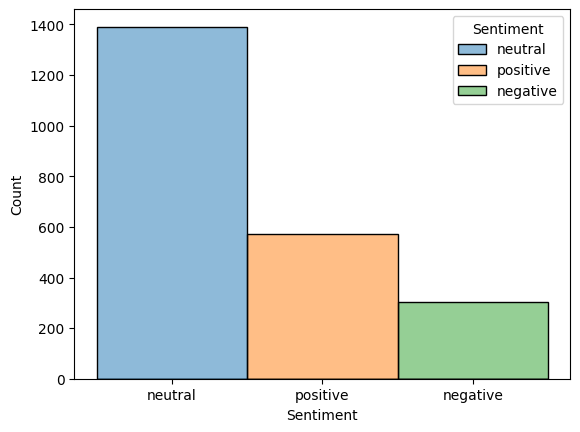

In [3]:
import seaborn as sns

# Histogram of classes
sns.histplot(data=df, x='Sentiment', hue='Sentiment')

# Biased to neutral statements, to be expected. Might make for a less critical classifier. Review after model validation

<Axes: xlabel='Sentiment', ylabel='Text Length'>

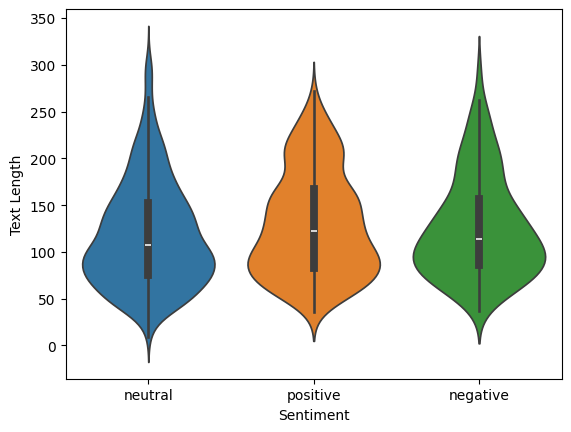

In [4]:
df['Text Length'] = [len(str) for str in df['Text']]
sns.violinplot(data=df, y='Text Length', x='Sentiment', hue='Sentiment')

# Seems lengths are more or less equal, perhaps slight bias (10%) indicating positive texts tend to be slightly longer than neutral and negative.
# Bulk of texts sit at just under 100 words. Note chunk of positive texts at ~220 words.

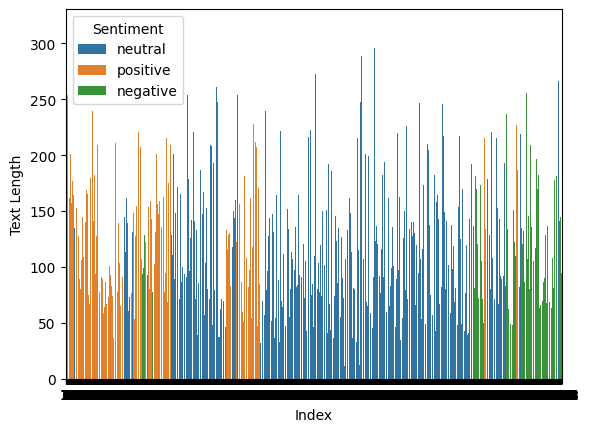

In [5]:
import matplotlib.pyplot as plt

fig = sns.barplot(data=df, y='Text Length', hue='Sentiment', x=df.index, )
fig.set(xlabel='Index')
plt.show()

# Distribution of word length and sentiment through dataset. Clumping of sentiments together will be resolved during stochastic batching.
# Can choose to remove outliers (>250) depending on expected input length in production.

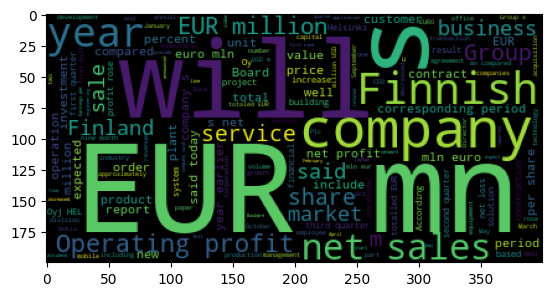

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=STOPWORDS).generate(' '.join(df['Text']))
plt.imshow(wc)

# Word cloud pre cleaning. We could benefit by removing common words/phrases like 's (apostrophe s), Oyj (Finnish for public stock company), ' ( HEL : [symbol] ) '
# Sentences end with ' .'. However, decimals also contain a space eg: '3 .4 million'. Take care while removing periods.

In [7]:
from sklearn.model_selection import train_test_split

smap = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment_label'] = df['Sentiment'].map(smap)
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'].tolist(), df['Sentiment_label'].tolist(), test_size=0.2, random_state=42)


In [9]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/Users/arjun/Documents/Finigami/AI ENGINEER - Application Assignment/FinancialPhraseBank-v1.0/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [12]:
from transformers import AdamW
from sklearn.metrics import classification_report
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_true.extend(labels.cpu().tolist())
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(classification_report(val_true, val_preds, target_names=['negative', 'neutral', 'positive']))

print("\nFinal Evaluation:")
print(classification_report(val_true, val_preds, target_names=['negative', 'neutral', 'positive']))

Epoch 1/3
              precision    recall  f1-score   support

    negative       0.84      0.96      0.90        56
     neutral       0.99      0.96      0.97       276
    positive       0.91      0.93      0.92       121

    accuracy                           0.95       453
   macro avg       0.92      0.95      0.93       453
weighted avg       0.95      0.95      0.95       453

Epoch 2/3
              precision    recall  f1-score   support

    negative       0.96      0.88      0.92        56
     neutral       0.97      0.98      0.97       276
    positive       0.91      0.93      0.92       121

    accuracy                           0.95       453
   macro avg       0.95      0.93      0.94       453
weighted avg       0.95      0.95      0.95       453

Epoch 3/3
              precision    recall  f1-score   support

    negative       0.85      0.93      0.89        56
     neutral       0.97      0.99      0.98       276
    positive       0.95      0.88      0.91  

## Analyzing performance

The most important metric here is f1 score, as this is a classification problem. We want to ensure maximum true positives and minimum False positives. An f1 score of 90% - 98% achieved here, represents a good enough model for deployment. In case we see frequent mislabelling after deployment, we can experiment with pre processing and hyperparameter tuning to increase model performance minimally.

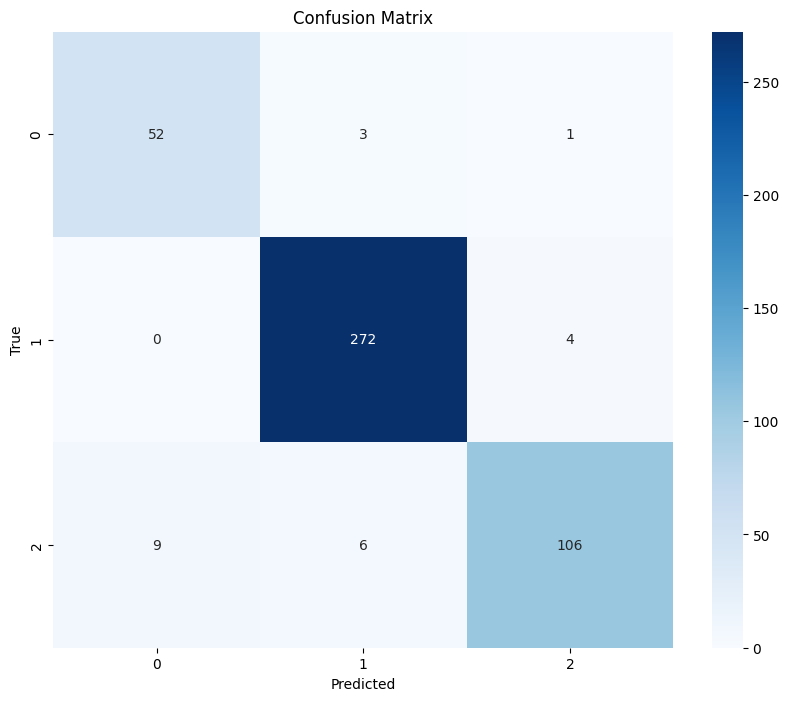

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
output_dir = './model_save/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

# Test API

In [29]:
# Make sure to run flaskapp.py to run the server. Expecting server to run on localhost:5000, if port number is different please modify 'port' below

port = 5000
import requests

url = f'http://127.0.0.1:{port}/predict'

In [18]:
news_excerpts = [
    'Akums Drugs and Pharmaceuticals makes positive debut, lists at 7% premium',
    'Markets slip after early gains! Nifty around 24,250, Sensex struggling to hold 79,400;',
    'India\'s Railways go high-tech: The track-laying process is powered by cutting-edge machinery.',
    'Marico slumps 4% on Bangladesh business continuity concerns',
    'Stocks To Watch: Bharti Airtel, ONGC, BEML, Adani Energy Solutions',
    'Global stock markets crash: Recession fears loom!',
    'Japan\'s stocks selloff on Monday seen as overdone: Invesco',
    'Adani Unveils $213 Billion Succession Plan as Scrutiny Persists',
    'Nvidia\'s Huang Sold $323 Million of Stock in July Before Decline',
    'Swift Downfall of Iron-Fisted Sheikh Hasina Marks New Era in Bangladesh'
]

for item in news_excerpts:
    data = {'text': item}
    response = requests.post(url, json=data)
    print(data['text']+'\t-- '+dict(response.json())['sentiment']+'\n\n')

Akums Drugs and Pharmaceuticals makes positive debut, lists at 7% premium	-- positive


Markets slip after early gains! Nifty around 24,250, Sensex struggling to hold 79,400;	-- negative


India's Railways go high-tech: The track-laying process is powered by cutting-edge machinery.	-- neutral


Marico slumps 4% on Bangladesh business continuity concerns	-- negative


Stocks To Watch: Bharti Airtel, ONGC, BEML, Adani Energy Solutions	-- neutral


Global stock markets crash: Recession fears loom!	-- negative


Japan's stocks selloff on Monday seen as overdone: Invesco	-- neutral


Adani Unveils $213 Billion Succession Plan as Scrutiny Persists	-- neutral


Nvidia's Huang Sold $323 Million of Stock in July Before Decline	-- neutral


Swift Downfall of Iron-Fisted Sheikh Hasina Marks New Era in Bangladesh	-- negative




## Test it Yourself:

In [31]:
YOUR_TEXT_HERE = 'The company reported strong earnings this quarter.'

data = {'text': f'{YOUR_TEXT_HERE}'}
response = requests.post(url, json=data)
print(dict(response.json())['sentiment'].upper())

POSITIVE
